In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from skimage import io, transform
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

In [33]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, labels = sample['image'], sample['label']

        h, w = image.shape[:2]

        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return {'image': torch.tensor(img,dtype=torch.float32), 'label': torch.tensor(labels,dtype=torch.float32)}

In [34]:
#
class traffic_sign(Dataset):
    def __init__(self, root_dir ):

        # initialize dataset variables here
        # self.root = root_dir
        self.root = Path(root_dir)

        self.df = pd.DataFrame(columns = ['image_names','class_label'])

        for fldr in self.root.iterdir():
          img_names = []
          if fldr.is_dir():
            img_names = img_names + list(fldr.glob('*.ppm'))

          img_names = [i for i in img_names]
          df_cur = pd.DataFrame(img_names,columns = ['image_names'])
          df_cur['class_label'] = fldr.name
          self.df = pd.concat([self.df, df_cur],axis=0)

        self.df = self.df.sample(frac=1)
        # self.df = self.df.head(2000)

        dummies = pd.get_dummies(data=self.df, columns = ['class_label'])
        self.df = self.df.merge(dummies,on='image_names')
        self.image_names = list(self.df['image_names'].values)
        self.class_label = self.df.iloc[:,2:].values.tolist()


    def __len__(self):
        # returns the length of the dataset
        return len(self.image_names)

    def __getitem__(self, idx):

        # preprocess and transformations
        # indexes the dataset such that dataset[i] can retrieve the ith sample.
        image = self.image_names[idx]
        image_data = io.imread(image)
        label = torch.tensor(self.class_label[idx])

        sample = {'image': image_data, 'label': label}
        scale = Rescale((256,256))
        sample = scale(sample)
        # print (sample['image'].shape)
        img = sample['image'].permute(2,0,1)
        ## h,w,c --> c, h, w
        ## 0,1,2 --> 2, 0, 1
        # print (img.shape)

        return {'image':img,'label':torch.tensor(label,dtype=torch.float32)}
        # return sample

In [35]:
traffic_sign_dataset = traffic_sign('/content/drive/MyDrive/3semester/8160/hw3/data')

In [ ]:
# traffic_sign_dataset = traffic_sign('data')

In [36]:
for i, sample in enumerate(traffic_sign_dataset):
  print(i, sample['image'].shape, sample['label'])
  if i == 3:
    break

0 torch.Size([3, 256, 256]) tensor([1., 0.])
1 torch.Size([3, 256, 256]) tensor([1., 0.])
2 torch.Size([3, 256, 256]) tensor([1., 0.])
3 torch.Size([3, 256, 256]) tensor([1., 0.])


In [ ]:
# img = sample['image'].reshape(1,3,256,256)
# # print (img.shape)
# tfobj = TraffSignModel_pre(3,5)
# out = tfobj(img)
# print (out)

In [37]:
class TraffSignModel(nn.Module):

    def __init__(self,input_dim,num_classes):
        super(TraffSignModel, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=input_dim, out_channels=32, kernel_size=3,stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3,stride=2),
            nn.ReLU()
        )


        self.dense_layers = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(128*31*31, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )


    def forward(self, x):
        x = self.conv_layers(x)
        # x = torch.flatten(x)
        x = x.view(-1,128*31*31)
        x = self.dense_layers(x)
        return x

In [ ]:
# models.resnet18(weights='IMAGENET1K_V1')

In [ ]:
# img = sample['image'].reshape(16,3,256,256)
# # print (img.shape)
# tfobj = TraffSignModel_pre(3,5)
# out = tfobj(img)
# print (out)

In [38]:
from torchvision import datasets, models, transforms

class TraffSignModel_pre(nn.Module):

    def __init__(self,input_dim,num_classes):
        super(TraffSignModel_pre, self).__init__()
# choice the model you use
        self.conv_layers = models.resnet50(weights='IMAGENET1K_V1')
        layer_idx = 0
        for param in self.conv_layers.parameters():
          #only print >= 50
            # if layer_idx < 0:
            param.requires_grad = False
            # layer_idx +=1

        num_ftrs = self.conv_layers.fc.in_features
        # self.conv_layers.fc = nn.Linear(num_ftrs, num_classes)


        self.conv_layers.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )


    def forward(self, x):
        x = self.conv_layers(x)
        # print (x.shape)
        # x = torch.flatten(x)
        # print (x.shape)
        # x = x.view(-1,128*31*31)
        # x = self.dense_layers(x)
        return x

In [39]:
bs = 32
dataloader = DataLoader(traffic_sign_dataset, batch_size=bs, shuffle=True, num_workers=4,drop_last=True)

In [40]:
for i, sample in enumerate(dataloader):
  print (sample['image'].size(), sample['label'].size())
  if i == 1:
    break

torch.Size([32, 3, 256, 256]) torch.Size([32, 2])
torch.Size([32, 3, 256, 256]) torch.Size([32, 2])


In [41]:
for i, sample in enumerate(dataloader):
  print (sample['image'].size(), sample['label'].size())
  if i == 1:
    break

torch.Size([32, 3, 256, 256]) torch.Size([32, 2])
torch.Size([32, 3, 256, 256]) torch.Size([32, 2])


In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
classes = ['00013','00014']
channels,width,height = traffic_sign_dataset[0]['image'].shape
# model = TraffSignModel(channels, len(classes))
model = TraffSignModel_pre(channels,len(classes))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 165MB/s]


In [43]:
#How many layer is it
ix = 0
for param in model.parameters():
    print (param.requires_grad.ix)
    ix+=1



False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True


In [44]:
ix = 0
for param in model.parameters():
    ix+=1
    if param.requires_grad:
        print(param.requires_grad,ix)

True 160
True 161
True 162
True 163


In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)

cuda:0


In [22]:
print (outputs.shape, sample_batched['label'].shape)

NameError: name 'outputs' is not defined

In [46]:
mean_loss = []
losses = []
test_losses = []
mean_test_loss = []
n_epochs = 3
for it in tqdm(range(n_epochs)):
  # zero the parameter gradients
  for i_batch, sample_batched in enumerate(dataloader):
    optimizer.zero_grad()
    outputs = model(sample_batched['image'].to(device))
    loss = criterion(outputs, sample_batched['label'].to(device))
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

  mean_loss.append(np.mean(losses))
  mean_test_loss.append(np.mean(test_losses))
  if (it+1) % 1 == 0:
    print(f'Epoch {it+1}/{n_epochs}, Training Loss: {np.mean(losses):.4f}')

 33%|███▎      | 1/3 [00:54<01:49, 54.75s/it]

Epoch 1/3, Training Loss: 0.1321


 67%|██████▋   | 2/3 [01:51<00:55, 55.73s/it]

Epoch 2/3, Training Loss: 0.0742


100%|██████████| 3/3 [02:55<00:00, 58.58s/it]

Epoch 3/3, Training Loss: 0.0522


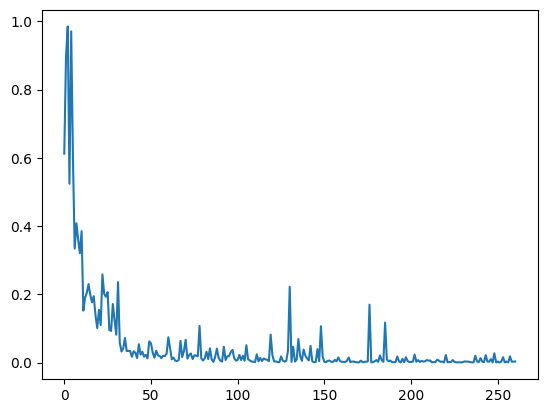

In [47]:
plt.plot(losses)

In [48]:
def evaluation(model,dataloader):
    softmax=nn.Softmax(dim=1)

    for i_batch, sample_batched in enumerate(dataloader):
        outputs = model(sample_batched['image'].to(device))
        targets_labels = sample_batched['label'].numpy()
        targets_images = sample_batched['image']
        # print (targets_images)
        outputs =softmax(outputs)
        cnt = 0
        fig = plt.figure(figsize=(20,20))
        ncols = 6
        for pred,target,imgs in zip(outputs,targets_labels,targets_images):
            imgs = imgs.permute(1,2,0)
            pred2numpy = pred.detach().cpu().numpy()
            max_id = np.argmax(pred2numpy)
            probs = pred2numpy[max_id]
            targ_id = np.argmax(target)
            # print (probs,classes[max_id],targ_id,imgs.shape)
            cnt+=1
            ax = plt.subplot(1, ncols, cnt)
            plt.tight_layout()
            ax.set_title('Sample {} - {}-{:.3f}%'.format(classes[targ_id], classes[max_id],probs))
            ax.axis('off')
            plt.imshow(imgs)

            if cnt == ncols:
                plt.show()
                break
        if i_batch == 2:
            break


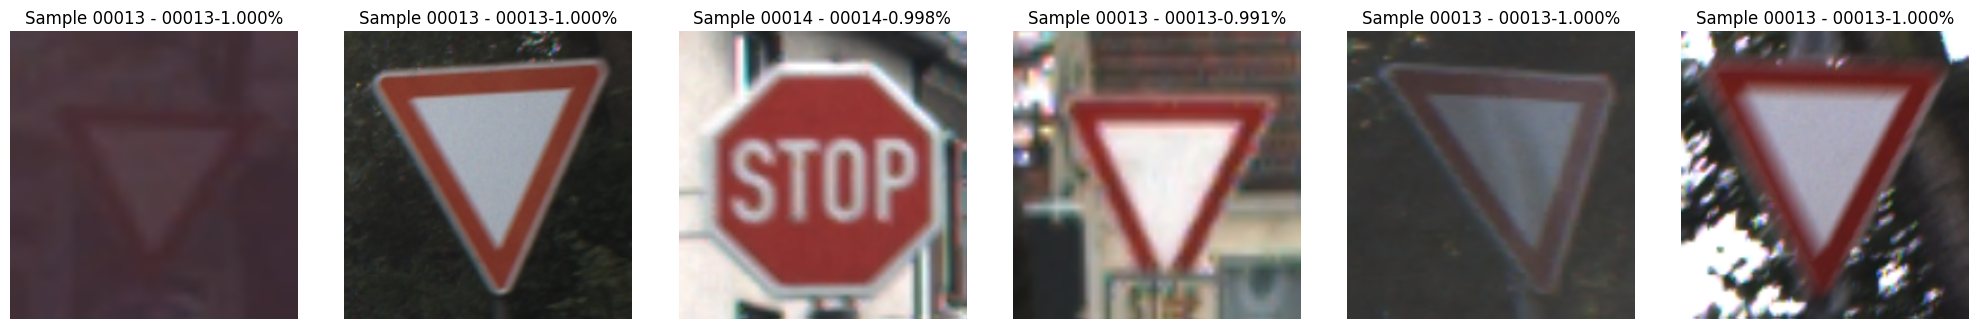

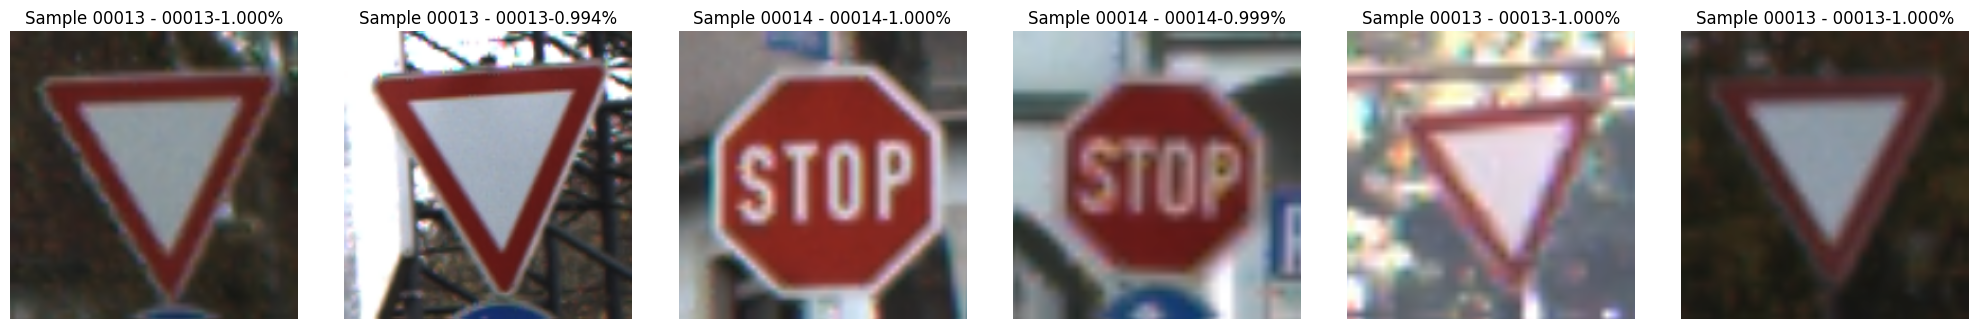

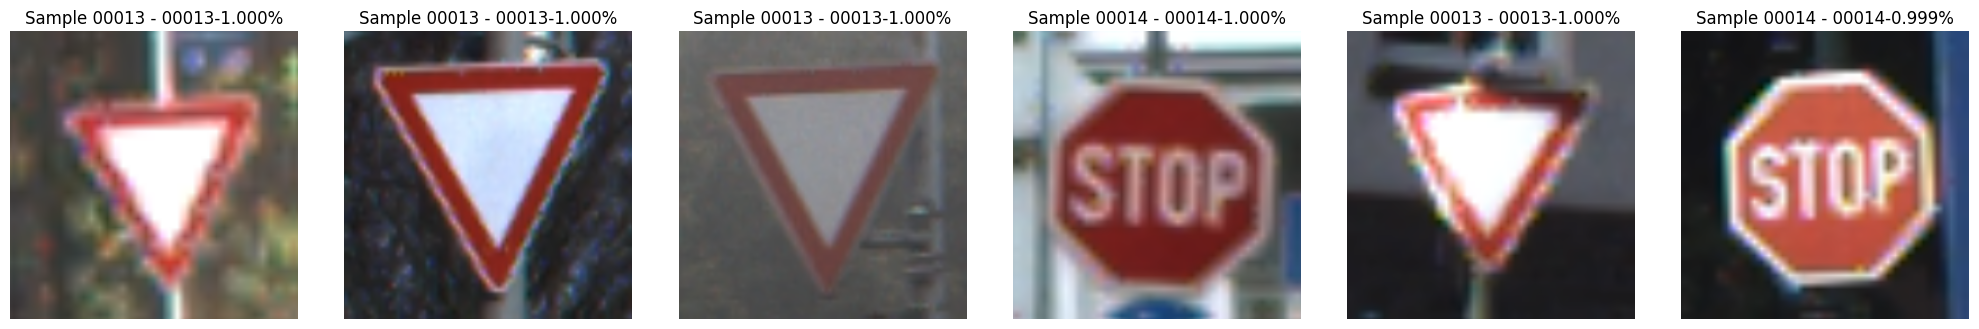

In [49]:
evaluation(model,dataloader)

In [50]:
img = sample['image']
# tfobj = TraffSignModel(3,5)
tfobj = TraffSignModel_pre(3,5)

In [55]:
# out = tfobj(img.reshape(1,3,256,256))

In [53]:
# print (out.shape)

## pretrained models

In [ ]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')

In [ ]:
# print (model_ft)

In [ ]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  